<a href="https://colab.research.google.com/github/Kieranosaurus/HYPER/blob/master/GAN_face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import PIL.Image
import tensorflow as tf
import os

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from google.colab import auth


gauth = GoogleAuth()
auth.authenticate_user()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

files = {"karras2018iclr-celebahq-1024x1024.pkl": "188K19ucknC6wg1R6jbuPEhTq9zoufOx4"}

for name, ID in files.items():
    download = drive.CreateFile({"id": ID})
    download.GetContentFile(name)

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4957666763725673041, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13247438682693940054
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17816433493932710346
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 942843282267843905
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
#BELANGRIJK
def face_from_latent(model, latents, my_path, save_image=True):
    dummy_label = np.zeros([1] + model.input_shapes[1][1:])
    for i in range(latents.shape[0]):
        latent = np.expand_dims(latents[i], 0)
        face = model.run(latent, dummy_label)
        face = np.clip(np.rint((face + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8)
        face = face.transpose((0, 2, 3, 1))

        if save_image:
            if not os.path.exists(my_path):
                os.mkdir(my_path)
            save_path = os.path.join(my_path, '%d.png' % i)
            Image.fromarray(face[0], 'RGB').save(save_path)
        else:
            Image.fromarray(face[0], 'RGB').show()
        
        # Load the images and display them
        img = mpimg.imread(f"stimuli/%d.png" % i)
        plt.axis('off')
        plt.imshow(img)
        plt.show()

def get_latents(inputShape):
    latents = np.random.RandomState(1000).randn(1000, inputShape)
    selection = np.random.choice(1000, 10)
    print("Selected latent vectors: ", selection)
    latents = latents[selection]
    return latents

def load_network(dev):
    p = "karras2018iclr-celebahq-1024x1024.pkl"
    with tf.device('/gpu:0'):
        _, _, Gs = pickle.load(open(p, "rb"))  
    weights = sess.run(tf.trainable_variables())
    with open('pggan_weights', 'wb') as f:
        pickle.dump(weights, f)
    return Gs

In [4]:
# Clean stimuli directory if necessary
!rm -rf stimuli

In [4]:
# Start interactive session
sess = tf.InteractiveSession()

In [5]:
# Load in the networks and load the weights
dev = 0
with tf.device('/gpu:%d' % dev):
    model = load_network(dev=dev)

Selected latent vectors:  [563 977 259 452 839 826 825 947 468 539]


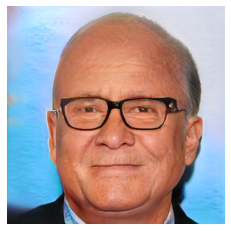

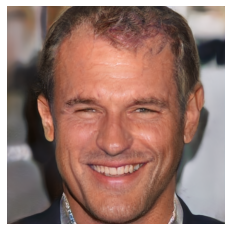

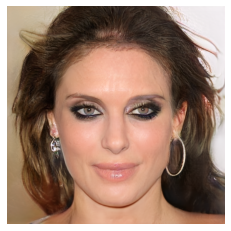

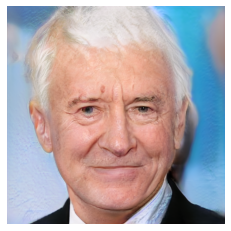

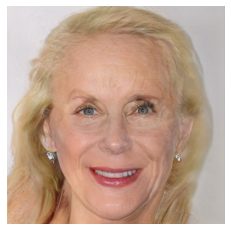

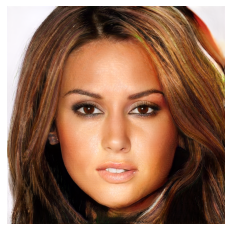

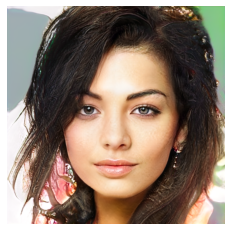

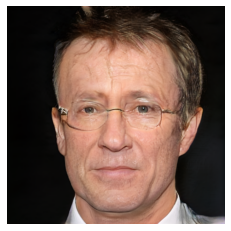

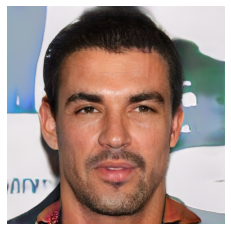

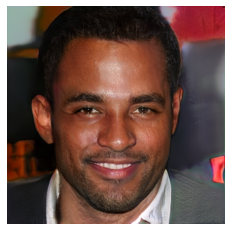

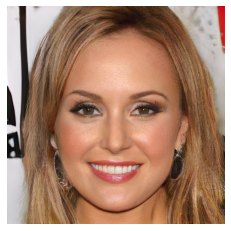

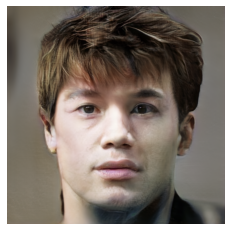

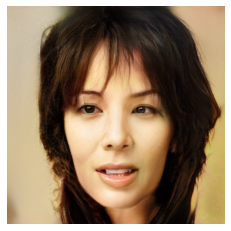

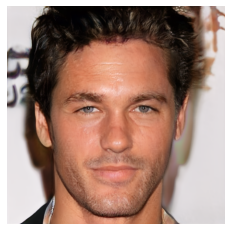

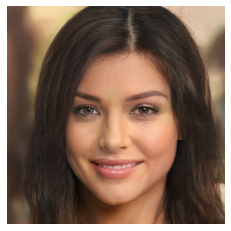

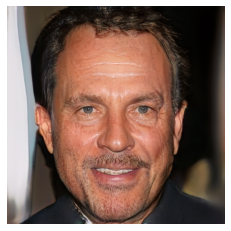

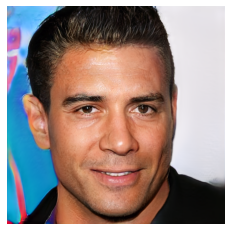

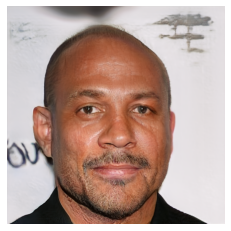

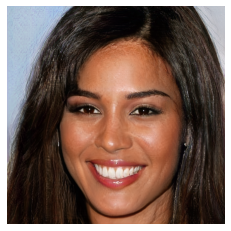

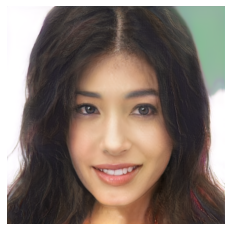

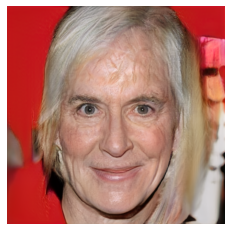

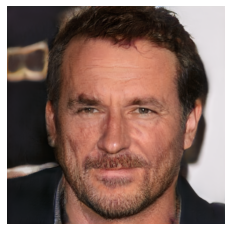

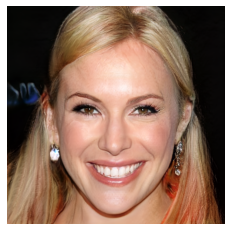

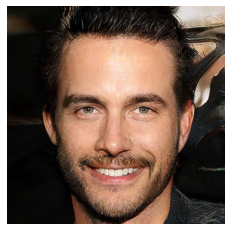

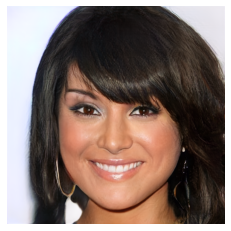

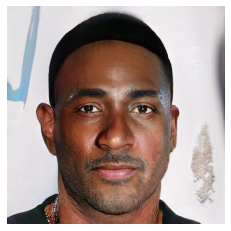

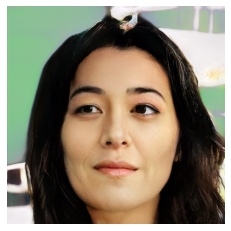

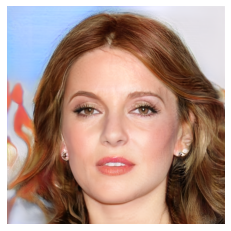

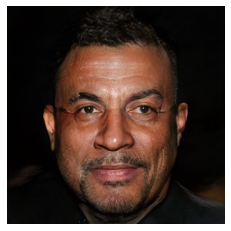

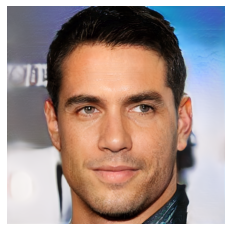

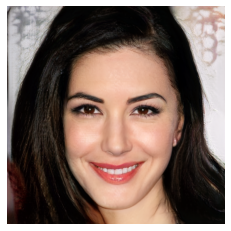

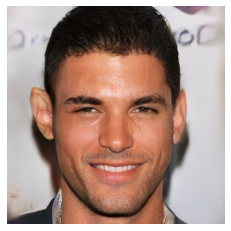

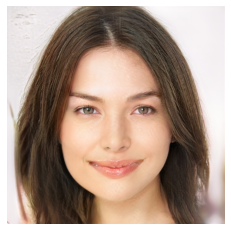

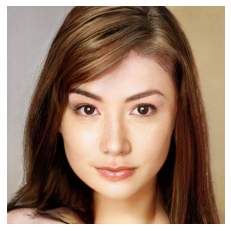

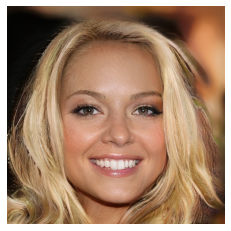

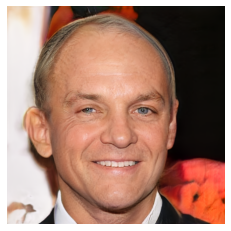

In [7]:
# Get random latents
latents = get_latents(*model.input_shapes[0][1:])

# Get latents from test data stimuli
with open('data_sub1_4096.dat', 'rb') as fp:
    _, _, _, T_test = pickle.load(fp)

# Generate faces.
face_from_latent(model, T_test, 'stimuli', save_image=True)

In [5]:
# Import chainer model files
from HYPER.main_chainer import *
from HYPER.progressive_grown_gan_chainer import *
from HYPER.myUtil import *

In [6]:
# Create chainer model
model = PGGC()
model = load_weights_from_tf(model)

# Run latents through model to generate faces
face = ch_face_from_latent(model, T_test, 'faces_chainer')

In [8]:
# Close TensorFlow session once done.
sess.close()